# MSADS509 Group 3 Final Project EDA and Modeling

In [1]:
import datetime
import random
import time
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from collections import defaultdict, Counter

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import re
import spacy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.metrics import accuracy_score, classification_report

from scipy.sparse import hstack

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from pandas import json_normalize

nlp = spacy.load('en_core_web_sm')

from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /Users/UE/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/UE/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Load data from desktop MSADS509_News_Project_Dataset folder

In [2]:
# make sure your directory is the same one that was used to store the cleaned dataframe
df = pd.read_csv('/Users/UE/Desktop/MSADS509_News_Project_Dataset/cleaned.csv')

def clean_tokens(tokens):
    return [token.strip("[]'") for token in tokens.split(', ')]

df['tokens'] = df['tokens'].apply(clean_tokens)
df

,source,url,content,tokens
0,cnn,https://www.cnn.com/2024/02/16/politics/russia...,Russia is trying to develop a nuclear space we...,"[russia, trying, develop, nuclear, space, weap..."
1,cnn,https://www.cnn.com/2024/02/15/politics/takeaw...,The Georgia election subversion case against T...,"[georgia, election, subversion, case, trump, 1..."
2,cnn,https://www.cnn.com/2024/02/16/politics/biden-...,The Norfolk Southern train derailment that sen...,"[norfolk, southern, train, derailment, sent, t..."
3,cnn,https://www.cnn.com/2024/02/16/politics/gaetz-...,The House Ethics Committee investigating Rep. ...,"[house, ethics, committee, investigating, rep,..."
4,cnn,https://www.cnn.com/2024/02/16/politics/takeaw...,Judge Arthur Engoron hit Trump with his bigges...,"[judge, arthur, engoron, hit, trump, biggest, ..."
...,...,...,...,...
235,foxnews,https://www.foxnews.com/politics/senate-foreig...,Fate of foreign aid bill remains uncertain aft...,"[fate, foreign, aid, bill, remains, uncertain,..."
236,foxnews,https://www.foxnews.com/politics/white-house-s...,Biden on release of classified docs report: 'T...,"[biden, release, classified, docs, report, mat..."
237,foxnews,https://www.foxnews.com/politics/house-gop-tes...,Jean-Pierre defends Biden mental fitness and k...,"[jeanpierre, defends, biden, mental, fitness, ..."
238,foxnews,https://www.foxnews.com/politics/biden-garners...,It's very awkward to watch Biden try to engage...,"[awkward, watch, biden, try, engage, tiktok, r..."


## EDA for tokens

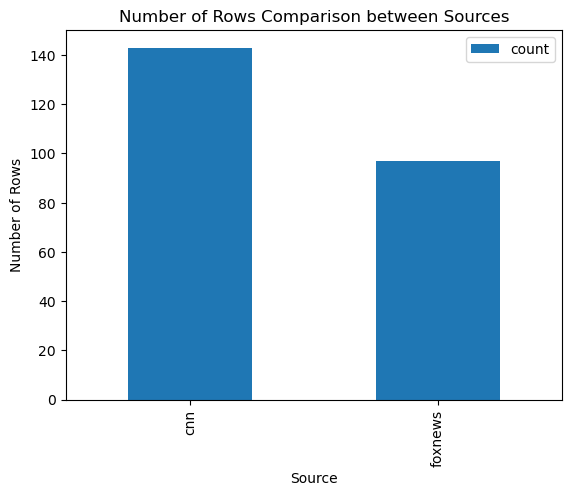

In [3]:
# Count the number of rows for each source
source_counts = df['source'].value_counts()

source_counts.plot(kind='bar', legend=True)
plt.xlabel('Source')
plt.ylabel('Number of Rows')
plt.title('Number of Rows Comparison between Sources')
plt.show()

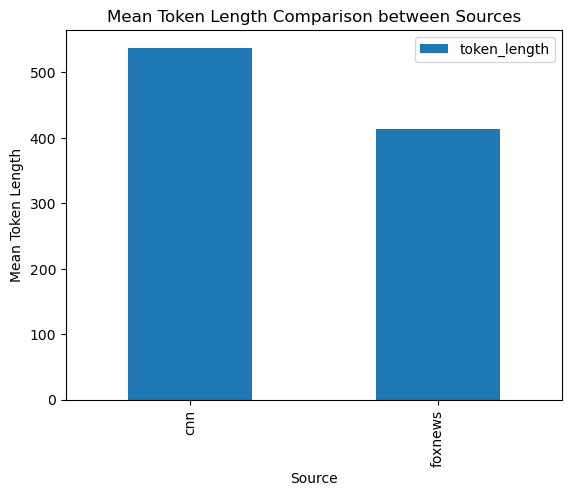

In [4]:
# the length of tokens for each article
df['token_length'] = df['tokens'].apply(lambda x: len(x))

source_token_length = df.groupby('source')['token_length'].mean()

source_token_length.plot(kind='bar', legend=True)
plt.xlabel('Source')
plt.ylabel('Mean Token Length')
plt.title('Mean Token Length Comparison between Sources')
plt.show()

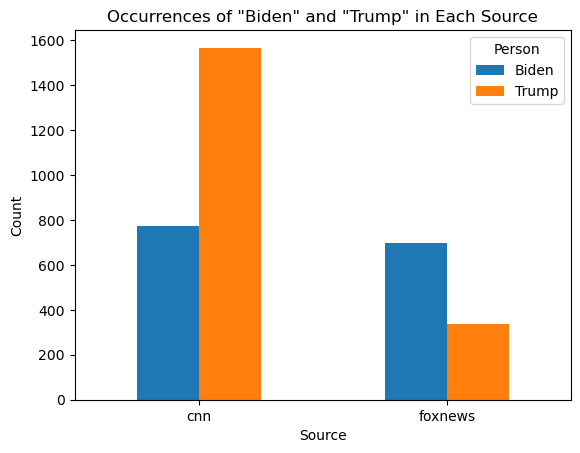

In [5]:
# count occurrences of a word in a list
def count_occurrences(tokens, word):
    return sum(1 for token in tokens if re.search(r'\b{}\b'.format(word), token, flags=re.IGNORECASE))

biden_counts = df.groupby('source')['tokens'].apply(lambda x: sum(count_occurrences(tokens, 'biden') for tokens in x))
trump_counts = df.groupby('source')['tokens'].apply(lambda x: sum(count_occurrences(tokens, 'trump') for tokens in x))

counts_df = pd.DataFrame({'Biden': biden_counts, 'Trump': trump_counts})

counts_df.plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Occurrences of "Biden" and "Trump" in Each Source')
plt.xticks(rotation=0)
plt.legend(title='Person')
plt.show()

## WordCloud for each Source

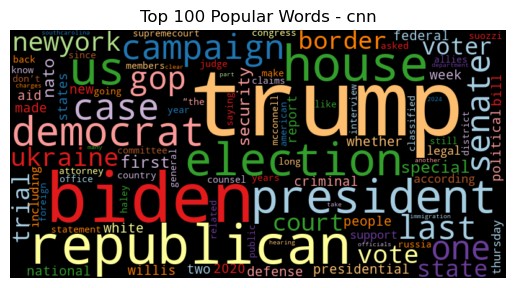

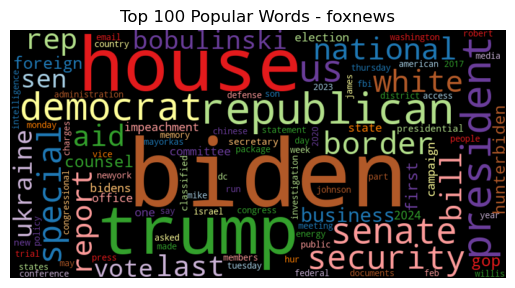

In [6]:

def wordcloud(df, title=None, max_words=100, stopwords=None):
    unique_sources = df['source'].unique()
    for source in unique_sources:
        tokens = df[df['source'] == source]['tokens']
        all_tokens = [token for sublist in tokens for token in sublist]
        counter = Counter(all_tokens)

        # Filter stop words in frequency counter
        if stopwords is not None:
            counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}

        wc = WordCloud(width=800, height=400,
                       background_color="black", colormap="Paired",
                       max_font_size=150, max_words=max_words)
        wc.generate_from_frequencies(counter)
        
        plt.title(f"{title} - {source}")
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

wordcloud(df, title="Top 100 Popular Words")


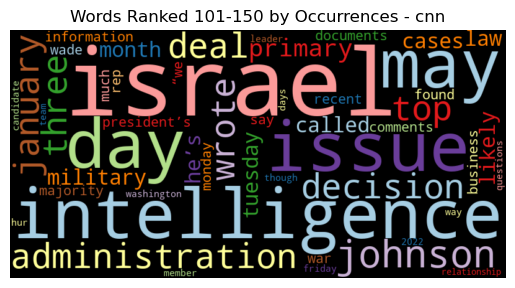

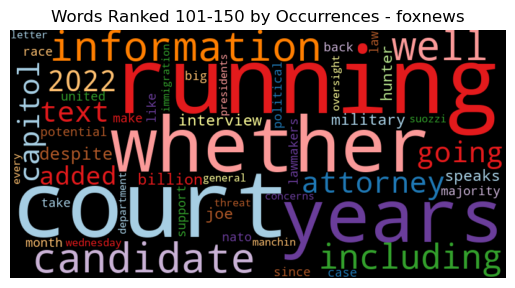

In [7]:

def wordcloud(df, title=None, max_words=200, stopwords=None):
    unique_sources = df['source'].unique()
    for source in unique_sources:
        tokens = df[df['source'] == source]['tokens']
        all_tokens = [token for sublist in tokens for token in sublist]
        counter = Counter(all_tokens)

        # Filter stop words in frequency counter
        if stopwords is not None:
            counter = {token: freq for (token, freq) in counter.items() if token not in stopwords}

        # Sort the counter by frequency and get the words ranked from 101st to 150th
        sorted_counter = dict(counter.most_common())
        words_101_to_150 = dict(list(sorted_counter.items())[100:150])

        wc = WordCloud(width=800, height=400,
                       background_color="black", colormap="Paired",
                       max_font_size=150, max_words=max_words)
        wc.generate_from_frequencies(words_101_to_150)
        
        plt.title(f"{title} - {source}")
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

wordcloud(df, title="Words Ranked 101-150 by Occurrences")


## Modeling and Model Evaluations

## Topic Modeling

In [8]:
sw = stopwords.words("english")
punctuation = set(punctuation) # speeds up comparison
extra_sw = ['cnn', 'fox', 'news', 'said', '-', '-', '--', '—','told', 'would', 'read', 'get', 'could', 
            'also', "it's", 'think', 'time', 'even', 'former', 'party', 'i', '“i', "she's", 'says', 
            'images', 'getty', 'im', 'this', 'we', 'it', 'digital', 'the', 'that', 'story', 'doesn']
sw.extend(extra_sw)

In [9]:
# define the topic displaying function
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [10]:
# create separate dataframes for the two news sources
cnn_df = df[df['source'] == 'cnn']
fox_df = df[df['source'] == 'foxnews']

# define the function to join tokens back into a string
def join_tokens(tokens):
    return ' '.join(tokens)

# Apply the join_tokens function to the "tokens" column
cnn_df["tokens_str"] = cnn_df["tokens"].apply(join_tokens)
fox_df["tokens_str"] = fox_df["tokens"].apply(join_tokens)

In [11]:
cnn_df

,source,url,content,tokens,token_length,tokens_str
0,cnn,https://www.cnn.com/2024/02/16/politics/russia...,Russia is trying to develop a nuclear space we...,"[russia, trying, develop, nuclear, space, weap...",513,russia trying develop nuclear space weapon des...
1,cnn,https://www.cnn.com/2024/02/15/politics/takeaw...,The Georgia election subversion case against T...,"[georgia, election, subversion, case, trump, 1...",842,georgia election subversion case trump 14 alli...
2,cnn,https://www.cnn.com/2024/02/16/politics/biden-...,The Norfolk Southern train derailment that sen...,"[norfolk, southern, train, derailment, sent, t...",558,norfolk southern train derailment sent toxins ...
3,cnn,https://www.cnn.com/2024/02/16/politics/gaetz-...,The House Ethics Committee investigating Rep. ...,"[house, ethics, committee, investigating, rep,...",97,house ethics committee investigating rep matt ...
4,cnn,https://www.cnn.com/2024/02/16/politics/takeaw...,Judge Arthur Engoron hit Trump with his bigges...,"[judge, arthur, engoron, hit, trump, biggest, ...",1117,judge arthur engoron hit trump biggest punishm...
...,...,...,...,...,...,...
217,cnn,https://www.cnn.com/2024/02/13/politics/suprem...,When it comes to deciding whether former Trump...,"[comes, deciding, whether, trump, booted, colo...",608,comes deciding whether trump booted colorado’s...
218,cnn,https://www.cnn.com/2024/02/13/politics/us-con...,North Korea watchers in Washington have fixate...,"[north, korea, watchers, washington, fixated, ...",726,north korea watchers washington fixated recent...
219,cnn,https://www.cnn.com/2024/02/12/politics/trump-...,Trump has endorsed North Carolina Republican P...,"[trump, endorsed, north, carolina, republican,...",343,trump endorsed north carolina republican chair...
220,cnn,https://www.cnn.com/2024/02/12/politics/cq-bro...,Chairman of the Joint Chiefs of Staff Gen. CQ ...,"[chairman, joint, chiefs, staff, gen, cq, brow...",471,chairman joint chiefs staff gen cq brown monda...


In [12]:
fox_df

,source,url,content,tokens,token_length,tokens_str
48,foxnews,https://www.foxnews.com/politics/joe-manchin-a...,"Joe Manchin suggests Mitt Romney, Rob Portman ...","[joe, manchin, suggests, mitt, romney, rob, po...",312,joe manchin suggests mitt romney rob portman p...
49,foxnews,https://www.foxnews.com/politics/mitt-romney-n...,"Joe Manchin suggests Mitt Romney, Rob Portman ...","[joe, manchin, suggests, mitt, romney, rob, po...",229,joe manchin suggests mitt romney rob portman p...
50,foxnews,https://www.foxnews.com/politics/dem-backed-ch...,Former CIA Director Leon Panetta warns that Ch...,"[cia, director, leon, panetta, warns, china, m...",529,cia director leon panetta warns china may use ...
51,foxnews,https://www.foxnews.com/politics/judiciary-cha...,"Biden hit for ESG agenda: 'Price goes up,' 'en...","[biden, hit, esg, agenda, price, goes, energy,...",734,biden hit esg agenda price goes energy becomes...
52,foxnews,https://www.foxnews.com/politics/house-democra...,"House Democrat group unveils plan for border, ...","[house, democrat, group, unveils, plan, border...",371,house democrat group unveils plan border immig...
...,...,...,...,...,...,...
235,foxnews,https://www.foxnews.com/politics/senate-foreig...,Fate of foreign aid bill remains uncertain aft...,"[fate, foreign, aid, bill, remains, uncertain,...",520,fate foreign aid bill remains uncertain passin...
236,foxnews,https://www.foxnews.com/politics/white-house-s...,Biden on release of classified docs report: 'T...,"[biden, release, classified, docs, report, mat...",247,biden release classified docs report matter cl...
237,foxnews,https://www.foxnews.com/politics/house-gop-tes...,Jean-Pierre defends Biden mental fitness and k...,"[jeanpierre, defends, biden, mental, fitness, ...",319,jeanpierre defends biden mental fitness knocks...
238,foxnews,https://www.foxnews.com/politics/biden-garners...,It's very awkward to watch Biden try to engage...,"[awkward, watch, biden, try, engage, tiktok, r...",580,awkward watch biden try engage tiktok roma dar...


In [13]:
# create our count text vectorizers 
cnn_count_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
cnn_count_text_vectors = cnn_count_text_vectorizer.fit_transform(cnn_df["tokens_str"])
print(cnn_count_text_vectors.shape)

fox_count_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
fox_count_text_vectors = fox_count_text_vectorizer.fit_transform(fox_df["tokens_str"])
print(fox_count_text_vectors.shape)

(143, 3694)
(97, 2361)


In [14]:
# create our tf-idf text vectorizers 
cnn_tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
cnn_tfidf_text_vectors = cnn_tfidf_text_vectorizer.fit_transform(cnn_df['tokens_str'])
print(cnn_tfidf_text_vectors.shape)

fox_tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(sw), min_df=3, max_df=0.7)
fox_tfidf_text_vectors = fox_tfidf_text_vectorizer.fit_transform(fox_df['tokens_str'])
print(fox_tfidf_text_vectors.shape)

(143, 3694)
(97, 2361)


### Fitting a Non-Negative Matrix Factorization Model

#### 5 Topics

In [15]:
# fit our NMF models
cnn_nmf_model = NMF(n_components=5, random_state=314)
cnn_W_nmf_matrix = cnn_nmf_model.fit_transform(cnn_tfidf_text_vectors)
cnn_H_nmf_matrix = cnn_nmf_model.components_

fox_nmf_model = NMF(n_components=5, random_state=315)
fox_W_nmf_matrix = fox_nmf_model.fit_transform(fox_tfidf_text_vectors)
fox_H_nmf_matrix = fox_nmf_model.components_

In [16]:
# assertion statements to ensure the document-topic and topic-feature matrices have the intended shapes
assert cnn_W_nmf_matrix.shape == (143, 5), f"Expected shape (143, 5), but got {cnn_W_nmf_matrix.shape}"
assert cnn_H_nmf_matrix.shape == (5, 3694), f"Expected shape (5, 3694), but got {cnn_H_nmf_matrix.shape}"
assert fox_W_nmf_matrix.shape == (97, 5), f"Expected shape (97, 5), but got {fox_W_nmf_matrix.shape}"
assert fox_H_nmf_matrix.shape == (5, 2361), f"Expected shape (5, 2361), but got {fox_H_nmf_matrix.shape}"

In [17]:
display_topics(cnn_nmf_model, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (2.40)
  case (1.01)
  trial (0.86)
  willis (0.86)
  court (0.79)

Topic 01
  bill (1.53)
  aid (1.52)
  ukraine (1.51)
  senate (1.44)
  border (1.41)

Topic 02
  biden (1.82)
  hur (1.69)
  report (1.22)
  classified (1.11)
  documents (0.94)

Topic 03
  suozzi (1.99)
  democrat (1.29)
  pilip (0.99)
  santos (0.96)
  republican (0.85)

Topic 04
  nato (2.03)
  trump (1.57)
  us (0.88)
  russia (0.74)
  biden (0.63)


In [18]:
display_topics(fox_nmf_model, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  aid (1.18)
  senate (1.03)
  border (1.03)
  bill (0.96)
  package (0.91)

Topic 01
  bobulinski (3.24)
  hunterbiden (2.35)
  2017 (1.10)
  business (1.07)
  hunter (1.05)

Topic 02
  hur (1.31)
  report (1.20)
  special (1.18)
  counsel (1.10)
  classified (1.04)

Topic 03
  trump (2.53)
  election (0.89)
  haley (0.71)
  republican (0.69)
  suozzi (0.67)

Topic 04
  manchin (5.34)
  romney (3.46)
  sen (2.41)
  mitt (2.35)
  running (2.17)


In [19]:
cnn_W_nmf_matrix.sum(axis=0)/cnn_W_nmf_matrix.sum()*100.0

array([18.83773848, 21.55326984, 19.84592222, 17.63775704, 22.12531242])

In [20]:
fox_W_nmf_matrix.sum(axis=0)/fox_W_nmf_matrix.sum()*100.0

array([20.6272055 , 17.44207487, 25.82667097, 26.55021884,  9.55382982])

#### 4 Topics

In [21]:
# fit our NMF models 4
cnn_nmf_model4 = NMF(n_components=4, random_state=314)
cnn_W_nmf_matrix4 = cnn_nmf_model4.fit_transform(cnn_tfidf_text_vectors)
cnn_H_nmf_matrix4 = cnn_nmf_model4.components_

fox_nmf_model4 = NMF(n_components=4, random_state=315)
fox_W_nmf_matrix4 = fox_nmf_model4.fit_transform(fox_tfidf_text_vectors)
fox_H_nmf_matrix4 = fox_nmf_model4.components_

In [22]:
display_topics(cnn_nmf_model4, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (2.50)
  case (0.86)
  trial (0.73)
  willis (0.70)
  election (0.69)

Topic 01
  ukraine (1.40)
  aid (1.24)
  bill (1.23)
  senate (1.14)
  border (1.10)

Topic 02
  biden (1.72)
  hur (1.38)
  report (1.02)
  classified (0.91)
  documents (0.76)

Topic 03
  suozzi (1.99)
  democrat (1.28)
  pilip (0.99)
  santos (0.96)
  republican (0.87)


In [23]:
display_topics(fox_nmf_model4, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  aid (1.17)
  senate (1.03)
  border (1.03)
  bill (0.95)
  package (0.90)

Topic 01
  bobulinski (3.23)
  hunterbiden (2.35)
  2017 (1.10)
  business (1.07)
  hunter (1.05)

Topic 02
  hur (1.31)
  report (1.20)
  special (1.19)
  counsel (1.10)
  classified (1.04)

Topic 03
  trump (2.37)
  election (0.82)
  republican (0.68)
  haley (0.66)
  suozzi (0.62)


In [24]:
cnn_W_nmf_matrix4.sum(axis=0)/cnn_W_nmf_matrix4.sum()*100.0

array([25.63818496, 28.66328296, 25.31400619, 20.3845259 ])

In [25]:
fox_W_nmf_matrix4.sum(axis=0)/fox_W_nmf_matrix4.sum()*100.0

array([22.66671548, 18.77975999, 27.66238914, 30.89113538])

### Fitting an LSA Model

#### 5 Topics

In [26]:
# fit our LSA models
cnn_svd_model = TruncatedSVD(n_components=5, random_state=320)
cnn_W_svd_matrix = cnn_svd_model.fit_transform(cnn_tfidf_text_vectors)
cnn_H_svd_matrix = cnn_svd_model.components_

fox_svd_model = TruncatedSVD(n_components=5, random_state=321)
fox_W_svd_matrix = fox_svd_model.fit_transform(fox_tfidf_text_vectors)
fox_H_svd_matrix = fox_svd_model.components_

In [27]:
# assertion statements to ensure the document-topic and topic-feature matrices have the intended shapes
assert cnn_W_nmf_matrix.shape == (143, 5), f"Expected shape (143, 5), but got {cnn_W_nmf_matrix.shape}"
assert cnn_H_nmf_matrix.shape == (5, 3694), f"Expected shape (5, 3694), but got {cnn_H_nmf_matrix.shape}"
assert fox_W_nmf_matrix.shape == (97, 5), f"Expected shape (97, 5), but got {fox_W_nmf_matrix.shape}"
assert fox_H_nmf_matrix.shape == (5, 2361), f"Expected shape (5, 2361), but got {fox_H_nmf_matrix.shape}"

In [28]:
display_topics(cnn_svd_model, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (1.31)
  biden (0.58)
  republican (0.45)
  election (0.40)
  case (0.34)

Topic 01
  ukraine (6.31)
  aid (5.76)
  bill (5.68)
  senate (5.50)
  border (5.25)

Topic 02
  biden (5.51)
  hur (5.25)
  report (3.73)
  classified (3.42)
  documents (2.88)

Topic 03
  suozzi (17.34)
  democrat (9.84)
  pilip (8.56)
  santos (8.33)
  newyork (6.58)

Topic 04
  nato (24.04)
  haley (12.41)
  trump (10.61)
  suozzi (9.32)
  biden (8.40)


In [29]:
display_topics(fox_svd_model, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (0.78)
  republican (0.46)
  senate (0.39)
  special (0.39)
  border (0.37)

Topic 01
  bobulinski (19.72)
  hunterbiden (15.01)
  business (7.09)
  2017 (7.02)
  hunter (6.75)

Topic 02
  hur (17.29)
  special (15.83)
  report (15.23)
  counsel (14.64)
  classified (14.01)

Topic 03
  trump (62.46)
  haley (21.38)
  election (21.17)
  willis (17.39)
  newyork (17.39)

Topic 04
  manchin (13.94)
  romney (9.03)
  sen (6.27)
  mitt (6.15)
  running (5.63)


In [30]:
cnn_W_svd_matrix.sum(axis=0)/cnn_W_svd_matrix.sum()*100.0

array([86.31330406,  6.24197075,  6.9370652 , -0.18872032,  0.69638031])

In [31]:
fox_W_svd_matrix.sum(axis=0)/fox_W_svd_matrix.sum()*100.0

array([89.78678694,  3.62967615, -0.69021173,  1.19199701,  6.08175163])

#### 4 Topics

In [32]:
# fit our LSA models 4
cnn_svd_model4 = TruncatedSVD(n_components=4, random_state=320)
cnn_W_svd_matrix4 = cnn_svd_model4.fit_transform(cnn_tfidf_text_vectors)
cnn_H_svd_matrix4 = cnn_svd_model4.components_

fox_svd_model4 = TruncatedSVD(n_components=4, random_state=321)
fox_W_svd_matrix4 = fox_svd_model4.fit_transform(fox_tfidf_text_vectors)
fox_H_svd_matrix4 = fox_svd_model4.components_

In [33]:
display_topics(cnn_svd_model4, cnn_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (1.31)
  biden (0.58)
  republican (0.45)
  election (0.40)
  case (0.34)

Topic 01
  ukraine (6.32)
  aid (5.77)
  bill (5.69)
  senate (5.50)
  border (5.25)

Topic 02
  biden (5.53)
  hur (5.27)
  report (3.75)
  classified (3.44)
  documents (2.89)

Topic 03
  suozzi (16.19)
  democrat (9.27)
  pilip (7.98)
  santos (7.78)
  newyork (6.15)


In [34]:
display_topics(fox_svd_model4, fox_tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  trump (0.78)
  republican (0.46)
  senate (0.39)
  special (0.39)
  border (0.37)

Topic 01
  bobulinski (19.79)
  hunterbiden (15.08)
  business (7.12)
  2017 (7.05)
  hunter (6.78)

Topic 02
  hur (16.84)
  special (15.42)
  report (14.84)
  counsel (14.27)
  classified (13.63)

Topic 03
  trump (55.69)
  election (18.93)
  haley (18.82)
  willis (15.70)
  newyork (15.38)


In [35]:
cnn_W_svd_matrix4.sum(axis=0)/cnn_W_svd_matrix4.sum()*100.0

array([ 8.68323013e+01,  6.27772899e+00,  6.96187877e+00, -7.19090064e-02])

In [36]:
fox_W_svd_matrix4.sum(axis=0)/fox_W_svd_matrix4.sum()*100.0

array([95.58531188,  3.863637  , -0.73487144,  1.28592256])

### Fitting an LDA Model

#### 5 Topics

In [37]:
# fit our LDA models
cnn_lda_model = LatentDirichletAllocation(n_components=5, random_state=40)
cnn_W_lda_matrix = cnn_lda_model.fit_transform(cnn_count_text_vectors)
cnn_H_lda_matrix = cnn_lda_model.components_

fox_lda_model = LatentDirichletAllocation(n_components=5, random_state=41)
fox_W_lda_matrix = fox_lda_model.fit_transform(fox_count_text_vectors)
fox_H_lda_matrix = fox_lda_model.components_

In [38]:
# assertion statements to ensure the document-topic and topic-feature matrices have the intended shapes
assert cnn_W_nmf_matrix.shape == (143, 5), f"Expected shape (143, 5), but got {cnn_W_nmf_matrix.shape}"
assert cnn_H_nmf_matrix.shape == (5, 3694), f"Expected shape (5, 3694), but got {cnn_H_nmf_matrix.shape}"
assert fox_W_nmf_matrix.shape == (97, 5), f"Expected shape (97, 5), but got {fox_W_nmf_matrix.shape}"
assert fox_H_nmf_matrix.shape == (5, 2361), f"Expected shape (5, 2361), but got {fox_H_nmf_matrix.shape}"

In [39]:
display_topics(cnn_lda_model, cnn_count_text_vectorizer.get_feature_names_out())


Topic 00
  us (1.78)
  republican (1.40)
  ukraine (1.23)
  trump (1.18)
  border (1.01)

Topic 01
  trump (4.85)
  case (1.62)
  election (1.08)
  trial (1.06)
  court (1.06)

Topic 02
  biden (2.81)
  trump (2.28)
  haley (0.72)
  report (0.69)
  campaign (0.68)

Topic 03
  biden (1.61)
  democrat (1.58)
  trump (1.50)
  republican (1.27)
  election (1.12)

Topic 04
  mcconnell (1.39)
  biden (1.25)
  hur (1.04)
  special (0.99)
  department (0.95)


In [40]:
display_topics(fox_lda_model, fox_count_text_vectorizer.get_feature_names_out())


Topic 00
  special (1.43)
  trump (1.30)
  report (1.02)
  counsel (0.96)
  hur (0.90)

Topic 01
  bobulinski (1.52)
  trump (1.40)
  hunterbiden (1.38)
  business (0.98)
  2017 (0.61)

Topic 02
  republican (2.15)
  senate (1.63)
  border (1.33)
  democrat (1.19)
  aid (1.11)

Topic 03
  climate (0.80)
  israel (0.79)
  tiktok (0.73)
  hamas (0.71)
  state (0.70)

Topic 04
  willis (1.35)
  trump (1.03)
  special (0.73)
  memory (0.71)
  harris (0.64)


In [41]:
# prepare our models for display
cnn_lda_display = pyLDAvis.lda_model.prepare(cnn_lda_model, cnn_count_text_vectors, cnn_count_text_vectorizer, sort_topics=False)
fox_lda_display = pyLDAvis.lda_model.prepare(fox_lda_model, fox_count_text_vectors, fox_count_text_vectorizer, sort_topics=False)

In [42]:
pyLDAvis.display(cnn_lda_display)

In [43]:
pyLDAvis.display(fox_lda_display)

#### 4 Topics

In [44]:
# fit our LDA models 4
cnn_lda_model4 = LatentDirichletAllocation(n_components=4, random_state=40)
cnn_W_lda_matrix4 = cnn_lda_model4.fit_transform(cnn_count_text_vectors)
cnn_H_lda_matrix4 = cnn_lda_model4.components_

fox_lda_model4 = LatentDirichletAllocation(n_components=4, random_state=41)
fox_W_lda_matrix4 = fox_lda_model4.fit_transform(fox_count_text_vectors)
fox_H_lda_matrix4 = fox_lda_model4.components_

In [45]:
display_topics(cnn_lda_model4, cnn_count_text_vectorizer.get_feature_names_out())


Topic 00
  republican (1.47)
  us (1.46)
  ukraine (1.17)
  border (1.13)
  aid (0.95)

Topic 01
  trump (4.58)
  case (1.51)
  election (1.06)
  trial (1.01)
  court (0.99)

Topic 02
  biden (2.59)
  trump (2.29)
  nato (0.93)
  report (0.84)
  hur (0.73)

Topic 03
  biden (1.66)
  democrat (1.56)
  trump (1.44)
  republican (1.22)
  election (1.07)


In [46]:
display_topics(fox_lda_model4, fox_count_text_vectorizer.get_feature_names_out())


Topic 00
  special (1.42)
  report (1.12)
  counsel (1.01)
  hur (0.91)
  white (0.88)

Topic 01
  trump (1.74)
  bobulinski (1.33)
  hunterbiden (1.20)
  business (0.87)
  willis (0.61)

Topic 02
  republican (2.05)
  senate (1.49)
  border (1.26)
  democrat (1.20)
  trump (1.11)

Topic 03
  climate (0.73)
  israel (0.72)
  state (0.68)
  hamas (0.67)
  tiktok (0.66)


In [47]:
cnn_lda_display4 = pyLDAvis.lda_model.prepare(cnn_lda_model4, cnn_count_text_vectors, cnn_count_text_vectorizer, sort_topics=False)
fox_lda_display4 = pyLDAvis.lda_model.prepare(fox_lda_model4, fox_count_text_vectors, fox_count_text_vectorizer, sort_topics=False)

In [48]:
pyLDAvis.display(cnn_lda_display4)

In [49]:
pyLDAvis.display(fox_lda_display4)

## Sentiment Analysis

In [50]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):

    text_str = ' '.join(text)
    return sid.polarity_scores(text_str)

# get sentiment scores for each news article
df['sentiment_scores'] = df['tokens'].apply(get_sentiment_scores)

# Extract compound sentiment scores (normalized score between -1 (most negative) and +1 (most positive))
df['compound_sentiment'] = df['sentiment_scores'].apply(lambda x: x['compound'])

threshold = 0.05

df['sentiment_label'] = df['compound_sentiment'].apply(lambda score: 'positive' if score > threshold else 'negative' if score < -threshold else 'neutral')

df.head()

,source,url,content,tokens,token_length,sentiment_scores,compound_sentiment,sentiment_label
0,cnn,https://www.cnn.com/2024/02/16/politics/russia...,Russia is trying to develop a nuclear space we...,"[russia, trying, develop, nuclear, space, weap...",513,"{'neg': 0.158, 'neu': 0.695, 'pos': 0.146, 'co...",-0.9150,negative
1,cnn,https://www.cnn.com/2024/02/15/politics/takeaw...,The Georgia election subversion case against T...,"[georgia, election, subversion, case, trump, 1...",842,"{'neg': 0.11, 'neu': 0.799, 'pos': 0.091, 'com...",-0.9808,negative
2,cnn,https://www.cnn.com/2024/02/16/politics/biden-...,The Norfolk Southern train derailment that sen...,"[norfolk, southern, train, derailment, sent, t...",558,"{'neg': 0.086, 'neu': 0.806, 'pos': 0.107, 'co...",0.8519,positive
3,cnn,https://www.cnn.com/2024/02/16/politics/gaetz-...,The House Ethics Committee investigating Rep. ...,"[house, ethics, committee, investigating, rep,...",97,"{'neg': 0.098, 'neu': 0.807, 'pos': 0.095, 'co...",-0.3400,negative
4,cnn,https://www.cnn.com/2024/02/16/politics/takeaw...,Judge Arthur Engoron hit Trump with his bigges...,"[judge, arthur, engoron, hit, trump, biggest, ...",1117,"{'neg': 0.167, 'neu': 0.759, 'pos': 0.074, 'co...",-0.9990,negative


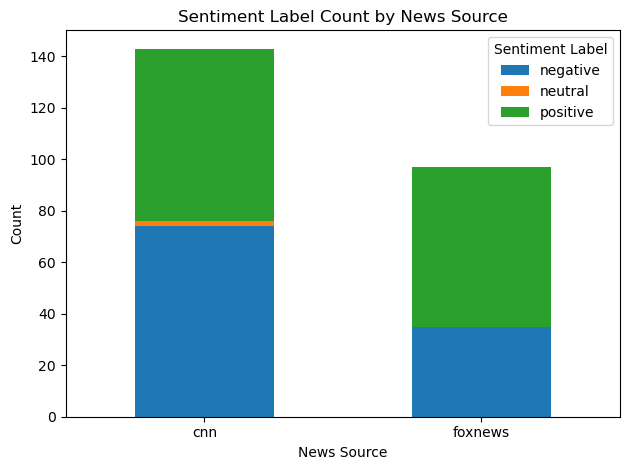

In [51]:
# Group by source and sentiment label and count occurrences
sentiment_counts = df.groupby(['source', 'sentiment_label']).size().unstack(fill_value=0)

sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Sentiment Label Count by News Source')
plt.xlabel('News Source')
plt.ylabel('Count')
plt.xticks(rotation=0)  
plt.legend(title='Sentiment Label')
plt.tight_layout() 
plt.show()

## Binary Classification - Source Prediction

## Predicting News Sources with Random Forest Classifier

In [52]:

# Define X and y
X = df['tokens']  
y = df['source']  

# Convert list of tokens into strings and remove stop words
X_str = X.apply(lambda x: ' '.join([token for token in x if token.lower() not in sw]))

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_str)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8958333333333334
Classification Report:
              precision    recall  f1-score   support

         cnn       0.85      1.00      0.92        28
     foxnews       1.00      0.75      0.86        20

    accuracy                           0.90        48
   macro avg       0.92      0.88      0.89        48
weighted avg       0.91      0.90      0.89        48



In [53]:

feature_importances = model.feature_importances_
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

top_n = 20 
print(f"Top {top_n} features and their importances:")
for feature, importance in sorted_feature_importances[:top_n]:
    print(f"Feature: {feature}, Importance: {importance}")

Top 20 features and their importances:
Feature: the, Importance: 0.017143589926628205
Feature: it, Importance: 0.013780135063664416
Feature: bidens, Importance: 0.009830682533642625
Feature: we, Importance: 0.007099595595822655
Feature: dc, Importance: 0.006916237754089141
Feature: according, Importance: 0.006417460318102642
Feature: feb, Importance: 0.006344317823718057
Feature: biden, Importance: 0.006151761327535434
Feature: this, Importance: 0.005980687126407469
Feature: content, Importance: 0.0053337228347321575
Feature: held, Importance: 0.005311335903234699
Feature: follow, Importance: 0.0050886157088580975
Feature: memory, Importance: 0.005072118963254376
Feature: enter, Importance: 0.004786222825985275
Feature: business, Importance: 0.004717108248530132
Feature: decision, Importance: 0.004402324810108792
Feature: that, Importance: 0.0040197439350161965
Feature: one, Importance: 0.00401614450523662
Feature: thats, Importance: 0.004011368268224521
Feature: two, Importance: 0.003

## Clustering

Top words per cluster for CNN:
Cluster 0: biden, hur, report, president, fbi, classified, austin, house, netanyahu, documents, 
Cluster 1: willis, trump, case, wade, engoron, trial, newyork, judge, attorney, hearing, 
Cluster 2: trump, nato, haley, biden, democrat, suozzi, republican, election, campaign, southcarolina, 
Cluster 3: ukraine, border, aid, bill, senate, republican, house, mcconnell, johnson, vote, 
Cluster 4: trump, supremecourt, court, case, immunity, election, trial, federal, smith, justices, 


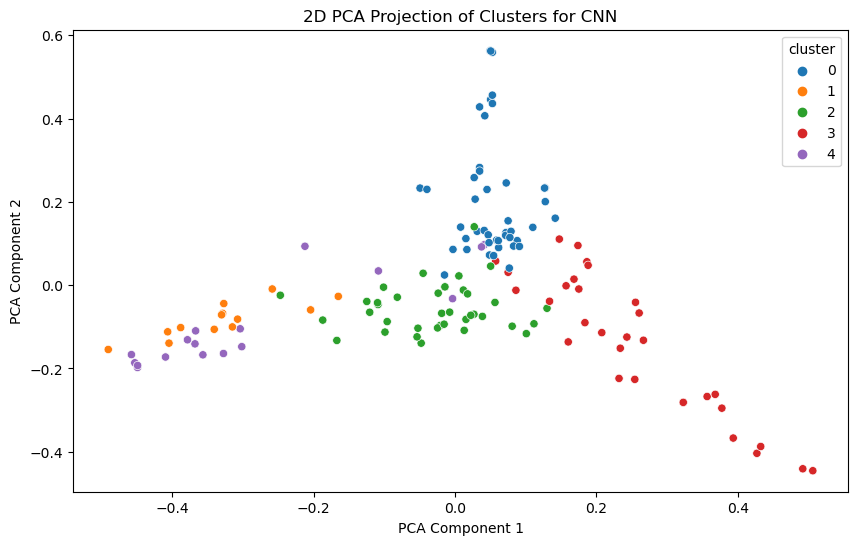

Top words per cluster for FoxNews:
Cluster 0: tiktok, climate, michigan, biden, campaign, cotton, app, sinema, schriver, chinese, 
Cluster 1: biden, special, hur, counsel, report, classified, memory, president, documents, robert, 
Cluster 2: house, aid, border, senate, bill, republican, ukraine, package, mayorkas, security, 
Cluster 3: bobulinski, hunterbiden, biden, hunter, business, 2017, fbi, cefc, smirnov, drug, 
Cluster 4: trump, manchin, willis, republican, haley, election, romney, sen, newyork, running, 


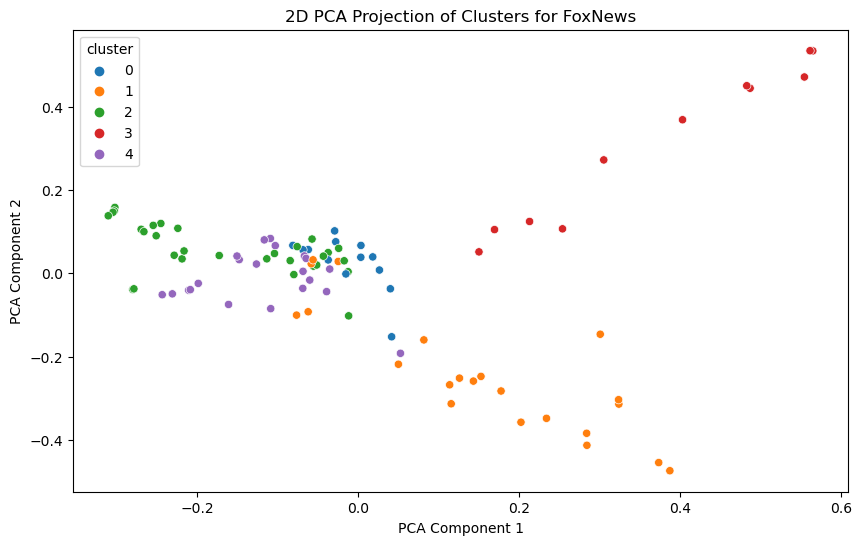

In [54]:

def cluster_and_plot(df, source_name):

    df['text'] = df['tokens'].apply(lambda x: ' '.join(x))
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

    # K-means clustering
    k = 5
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_tfidf)
    df['cluster'] = clusters

    # Print the top words per cluster
    print(f"Top words per cluster for {source_name}:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    for i in range(k):
        print(f"Cluster {i}: ", end='')
        for ind in order_centroids[i, :10]:
            print(f'{terms[ind]}', end=', ')
        print()

    # Reduce dimensions to 2D using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_tfidf.toarray())

    # Add PCA components to DataFrame
    df['pca1'] = X_pca[:, 0]
    df['pca2'] = X_pca[:, 1]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='tab10', legend='full')
    plt.title(f'2D PCA Projection of Clusters for {source_name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# CNN articles
df_cnn = df[df['source'] == 'cnn']
cluster_and_plot(df_cnn, 'CNN')

# FoxNews articles
df_fox = df[df['source'] == 'foxnews']
cluster_and_plot(df_fox, 'FoxNews')
